# Practical 2 : Generative and Discriminative Models


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on six
datasets. As part of the practical you should briefly read the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should implement a Naïve Bayes Classifier directly in python. To keep your code tidy,
we recommend implementing it as a class. Make sure that your classifier can handle binary, continuous and categorical features, and an arbitrary number of class labels. Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical, and that there are
4 classes. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'], num_classes=4)

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y | \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The fit function is expected to estimate all the parameters ($\theta$ and $\pi$) of the NBC. The predict function is expected to compute the probabilities that the new input belongs to all classes and
then return the class that has the largest probability.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries. 

In [1]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Before implementing NBC, we suggest you first implement the three types of the distributions of the parameters of NBC. Your implementation should have two functions: **estimate** and **get_probability**. The estimate function takes some data as input and computes the maximum likelihood estimators (MLE) for the parameters $\theta$ of the distribution $p(x | \theta)$. The get_probability function takes a new input value $x_{new}$ and returns $p(x_{new} | \theta)$. For example, in the case of continuous features, we can use the Gaussian distribution. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data, and the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma)$. 

![alt text](pics/mle_4.png)


You can import statistic libraries for the implementation of the distributions. We recommend using the statistical functions provided by `scipy.stats`. Read the documentation here: https://docs.scipy.org/doc/scipy/reference/stats.html


In [2]:
from scipy.stats import norm, bernoulli, multinomial

# Distribution for continuous features using norm distribution
class ContFeatureParam:
    def estimate(self, X):
        mu, var = norm.fit(X) # estimate parameters for gaussian distribution
        if (var == 0):
            var = 10 ** -4 # prevent variance being 0   
        return mu, var
    
    def get_probability(self, val, theta):
    
        # returns the density value of the input value val
        return norm.logpdf(val, theta[0], theta[1])
        

# Distribution for binary features using bernoulli distribution
class BinFeatureParam:
    def estimate(self, X):
        
        # count occurence of both classes
        classes, counts = np.unique(X, return_counts=True)

        size = len(X)

        # compute number of occurences of class 1
        if (len(classes) == 1): # in case only one class has been observed
            if(classes[0] == 0):
                x = 0
            else:
                x = size
        else: # in case both classes have been observed
            x = counts[1]   

        # compute p with laplace smoothing: (x + alpha) / (N + alpha * K), where K = 2 (number of classes), N = size of entries, alpha = 1 (smoothing parameter)
        return (x + 1.0) / (size + 1.0 * 2.0)

    def get_probability(self, val, theta):

        # compute probability mass function of array val with the value theta (p)
        return bernoulli.logpmf(val, theta)
       

# Distribution for categorical features using multinomial distribution
class CatFeatureParam:
    def estimate(self, X):

        # count occurence of all classes
        classes, counts = np.unique(X, return_counts=True)

        # compute p with laplace smoothing: (x + alpha) / (N + alpha * K), where K = number of classes, N = size of entries, alpha = 1 (smoothing parameter)
        return (counts + 1.0) / (len(X) + 1.0 * len(classes)), classes

    def get_probability(self, val, param):

        theta = param[0]
        classes_train = param[1]

        # compute size of arrays
        size_theta = len(theta)
        size_val = len(val)

        # count classes
        classes = np.unique(val)
        classes_count = len(classes) 

        # check if estimate function did not include all feature classes
        if classes_count > size_theta:
            
            # check how many classes are missing
            missing_val = classes_count - size_theta

            # theta array must sum up to 1 but we change it later, we have to correct it
            deviation = 10 ** -4 * missing_val / size_theta

            # subtract deviation from theta array
            theta = theta - deviation

            # resize theta array because not every feature class is in theta array
            size_theta = classes_count
            
            # in case classes have been detected in the training but not in the testing data
            bool_array = np.logical_not(np.isin(classes_train, classes))
            
            # make sure theta has all classes
            if (np.any(bool_array)):
                missing_idx = np.where(bool_array)[0]
                size_theta += len(missing_idx)

            # get array with boolean to check missing class in testing data
            bool_array = np.logical_not(np.isin(classes, classes_train))

            # find index for missing feature class
            missing_idx = np.where(bool_array)[0]
            
            # convert theta array to list
            theta_list = list(theta)

            # insert missing class features into list on respective position
            for i in missing_idx:
                theta_list.insert(i, 10 ** -4) # probability should be close to zero because this values should not occur

            # convert list back to array
            theta = np.array(theta_list)

        # init input vector for probability mass function
        x = np.zeros(size_val * size_theta)

        # compute position for every row to the corresponding class than has occured
        pos = size_theta * np.arange(0,size_val)

        # compute index
        idx = val.T + pos 

        # set value at each index to 1
        x[idx] = 1

        # reshape matrix x such that the number of rows is equal to the number of rows in val and columns represent classes
        x = x.reshape((size_val,size_theta))

        # compute probability mass function of array val with the array theta [p_1,...,p_n]
        return multinomial.logpmf(x, 1, theta)

Let us now implement a class for NBC. We'll keep it simple and try to follow the sklearn models. We'll have an init function, fit function and predict function.

**Hints for function fit**: Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y | \pi) \cdot p(\mathbf{x} \mid y, \theta)$. 
The fit function will estimate the parameters for NBC based on the training data. 
Here we give you some hints how to estimate the $\theta$ in $p(\mathbf{x} \mid y, \theta)$. 

For each class $c$, we want to estimate the $\theta_c$ for the distribution $p(\mathbf{x} \mid y = c, \theta_c)$. 
Since the assumption of NBC that the features are conditionally independent given the class $c$, the class conditional distribution is a product of $D$ distributions, one for each feature: $p(\mathbf{x} \mid y = c, \theta_c) = \prod_{j}^{D} p(x_j \mid y = c, \theta_{jc})$. Hence, we need to estimate the $\theta_{jc}$ based on the data with class $c$ and feature $j$. 

![alt text](pics/fit_4.png)


**Hints for function predict**: The predict function should compute the probabilities $p(y = c \mid \mathbf{x}_{new}, \pi, \theta)$ for the new inputs $\mathbf{x}_{new}$ on all classes by applying the Bayes rule:

$$p(y = c \mid \mathbf{x}_{new}, \pi, \theta) = \frac{p(y = c \mid \pi_c) \cdot p(\mathbf{x}_{new} \mid y=c, \theta)}{\sum^{C}_{c'=1}p(y=c' \mid \pi_{c'}) \cdot p(\mathbf{x}_{new} \mid y=c', \theta_{c'})},$$

and then return the class that has the largest probability:

$$y_{predict} = \underset{c}{arg\,\max} \, {p(y = c \mid \mathbf{x}_{new}, \theta_c)}.$$

Here we give you some hints on the computation of $p(\mathbf{x}_{new} \mid y=c, \theta_c)$. 
Due to the conditional independence assumption, we have $p(\mathbf{x}_{new} \mid y=c, \theta_c) = \prod_{j}^{D} p(x^j_{new} \mid y = c, \theta_{jc})$. Since we have got the parameters $\theta_{jc}$ in the fit phase,  we can use them to compute the probabilities for the new data. 

![alt text](pics/predict_3.png)

In [3]:
class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['r', 'r', 'r', 'r']
    #   num_classes: number of classes of labels
    def __init__(self, feature_types=[], num_classes=0):   
        
        # array which defines the distribution classes
        feature_dist = [] 
        
        # define the distributions according to the feature type string
        for feature_type in feature_types:
            if (feature_type == 'r'):
                feature_dist.append(ContFeatureParam())
            elif (feature_type == 'b'):
                feature_dist.append(BinFeatureParam())
            elif (feature_type == 'c'):
                feature_dist.append(CatFeatureParam())
                
        self.feature_dist = feature_dist        
        self.num_classes = num_classes
    
    # The function uses the input data to estimate all the parameters of the NBC
    # You should use the parameters based on the types of the features
    def fit(self, X, y):

        # check if some values in matrix have missing values
        X_boolean = pd.isnull(X)
        
        # find index for all rows whose values are nan
        nan_idx = np.where(np.all(X_boolean, axis=1))
        
        # remove rows with above defined nan_idx from X and y dataset
        X = np.delete(X, nan_idx, axis=0)
        y = np.delete(y, nan_idx, axis=0)
        
        # extract sorted indices according to the y unique elements
        idx_y = np.argsort(y)
        
        # save y values according to sorted y indices
        y_sorted = y[idx_y] 
   
        # save the X values according to sorted y indices
        X_sorted = X[idx_y,:] 
 
        # use unique function to extract every class exactly once with the first occuring idx and the occurence
        self.classes, idx_first, counts = np.unique(y_sorted, return_counts=True, return_index=True) 
        
        # splits the training data into separate arrays for every class, we have to skip the first index because these indexes belong to the first class
        X_per_class = np.split(X_sorted, idx_first[1:])
        
        # compute pi per class c
        self.pi = counts / len(y)
        
        # array for estimated theta parameters per class c (row) for every feature j (column)
        self.theta = np.empty((self.num_classes,len(self.feature_dist)), object)

        # iterate over classes
        for class_idx,_ in enumerate(self.classes):
            # iterate over features
            for feature_idx,feature_class in enumerate(self.feature_dist):
                
                # extract all rows per class c for every feature
                X_per_class_feature = X_per_class[class_idx][:,feature_idx]
                
                # remove all nan values from array
                X_per_class_feature = X_per_class_feature[np.logical_not(pd.isnull(X_per_class_feature))]
              
                # compute theta per class c for every feature
                self.theta[class_idx, feature_idx] = feature_class.estimate(X_per_class_feature)
              
    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):
        
        # array with 𝑝(𝑦=𝑐∣𝜋𝑐)⋅𝑝(𝐱𝑛𝑒𝑤∣𝑦=𝑐,𝜃) for each class
        a = []
        
        # iterate over classes
        for class_idx,_ in enumerate(self.classes):
            
            # 𝑝(𝑦=𝑐∣𝜋𝑐) for each class in log scale
            ak = np.log(self.pi[class_idx])
            
            # iterate over features
            for feature_idx,feature_class in enumerate(self.feature_dist):
                
                X_per_feature = X[:,feature_idx]

                # check if some values in matrix have missing values
                X_per_feature_boolean = pd.isnull(X_per_feature)
 
                # find index for all entries whose values are nan
                nan_idx = np.argwhere(X_per_feature_boolean)
                            
                # set all missing values to 1 such that probability calculation throws no error\n",
                X_per_feature[nan_idx] = 1
                    
                # compute the numerator 𝑝(𝑦=𝑐∣𝜋𝑐)⋅𝑝(𝐱𝑛𝑒𝑤∣𝑦=𝑐,𝜃) for each class in log scale
                num = feature_class.get_probability(X_per_feature, self.theta[class_idx, feature_idx])
                    
                # set all missing values to 0 because these values should not contribute to the result
                num[nan_idx] = 0
                    
                # sum all numerators
                ak += num

            a.append(np.array(ak).T)
    
        # reshape the arrays such that every column is a class and every row is a training data input
        numerator = np.stack(a, axis=1)
        
        # get biggest probability for all classes
        p_max = np.max(numerator, axis=1)
        
        # apply the log-sum-exp trick to compute the denominator ∑𝐶𝑐′=1𝑝(𝑦=𝑐′∣𝜋𝑐′)⋅𝑝(𝐱𝑛𝑒𝑤∣𝑦=𝑐′,𝜃𝑐′)
        denominator = np.sum(np.exp(a - p_max), axis=0) # apply ∑e^(ak - p_max)

        # apply last part of log-sum-exp trick: by taking the log and adding p_max
        denominator = np.log(denominator) + p_max
        
        # compute 𝑝(𝑦=𝑐∣𝐱𝑛𝑒𝑤,𝜋,𝜃) for every class in log space (use tile on denominator to generate same shape as numerator by duplicate the column vector * number of classes)
        denominator = np.tile(denominator.T, (numerator.shape[1],1)).T
        p = numerator - denominator
        
        # find the largest probability for each data row 
        max_idx = np.argmax(p, axis=1)
        
        # return most probable class for each data row
        return self.classes[max_idx]

**Implementation Issues**
- Fell free to add auxiliary functions. 
- Don't forget to compute $p(y=c | \pi)$ 
- Remember to do all the calculations in log space to avoid running into underflow issues. Read more: (Mur) Chapter 3.5.3
- Your implementation should be able to handle missing values
- As far as possible use matrix operations. So assume that Xtrain, ytrain, Xtest will all
be numpy arrays. Try and minimise your use of python loops. (In general, looping over
classes or features is OK, but looping over data is probably not a good idea.)
- The variance parameter for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6.
Note that this is essential to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. Also, you want to ensure that the estimates for the parameter for the Bernoulli or Multinoulli random variables
is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).


You can use the below code to do sanity check of your implementation using the iris dataset. All features of the iris dataset are continuous, so you do not need to implement all types of feature parameters to check your code. 

You should expect your implementation has an accuracy larger than 90%. 

In [4]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
Ntrain = int(0.8 * N)
shuffler = np.random.permutation(N)
Xtrain = X[shuffler[:Ntrain]]
ytrain = y[shuffler[:Ntrain]]
Xtest = X[shuffler[Ntrain:]]
ytest = y[shuffler[Ntrain:]]

nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=3)
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy)

Accuracy: 0.9666666666666667


## Logistic Regression

For logistic regression, you should use the implementation in sklearn. Adding the following
line will import the LR model.

    from sklearn.linear_model import LogisticRegression

Read the information provided on the following links to understand some details about how the
logistic regression model is implemented in scikit-learn.
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


## Comparing NBC and LR

### Experiments

You will compare the classification error of the NBC and LR trained on increasingly
larger training datasets. Because the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a
function of the size of the training data. Plot these curves for NBC and LR on the datasets.

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data (train and testing data should be provided differently in case of missing values)
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps.
# outputs:
#   the arrays of the test errors across the runs of the two classifiers 
def compareNBCvsLR(nbc, lr, X_train_nbc, y_train_nbc, X_test_nbc, y_test_nbc, X_train_lr, y_train_lr, X_test_lr, y_test_lr, num_runs=1000, num_splits=10):
        
    # define split step size
    split_step = 100 / num_splits
    
    # define error arrays for both models for all splits
    tst_errs_nbc = np.zeros((num_splits))
    tst_errs_lr = np.zeros((num_splits))
  
    # increase dataset per iteration
    for split in range(1,num_splits + 1):
        
        # define the percentage of data to be used
        percentage = split * split_step / 100

        # define error arrays for both models for all runs
        tst_errs_runs_nbc = np.zeros((num_runs))
        tst_errs_runs_lr = np.zeros((num_runs))
        
        for run in range(num_runs):
            
            # define the split data
            X_split_nbc = X_train_nbc
            y_split_nbc = y_train_nbc
            X_split_lr = X_train_lr
            y_split_lr = y_train_lr

            # only when not whole dataset should be used
            if (percentage != 1.0):

                # use stratified split to ensure that all classes appear in the split data
                sss = StratifiedShuffleSplit(n_splits=1, train_size=percentage)

                # split for nbc data
                for train_index, _ in sss.split(X_split_nbc, y_split_nbc):
                    X_split_nbc = X_split_nbc[train_index]
                    y_split_nbc = y_split_nbc[train_index]
    
                # split for logistic regression data
                for train_index, _ in sss.split(X_split_lr, y_split_lr):
                    X_split_lr = X_split_lr[train_index]
                    y_split_lr = y_split_lr[train_index]
            
            # fit & predict nbc
            nbc.fit(X_split_nbc, y_split_nbc)
            yhat_nbc = nbc.predict(X_test_nbc)
            tst_errs_runs_nbc[run] = 1 - np.mean(yhat_nbc == y_test_nbc) # compute error
            
            # fit & predict logistic regression
            clf = lr.fit(X_split_lr, y_split_lr)
            yhat_lr = clf.predict(X_test_lr)
            tst_errs_runs_lr[run] = 1 - np.mean(yhat_lr == y_test_lr) # compute error
        
        # compute average after all runs for each split
        tst_errs_nbc[split-1] = np.average(tst_errs_runs_nbc)
        tst_errs_lr[split-1] = np.average(tst_errs_runs_lr)
    
    return tst_errs_nbc, tst_errs_lr


The utility function below defines the function for plotting. 

In [6]:
def makePlot(nbc_perf, lr_perf, title=None):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * 10 for i in range(10)]
    plt.plot(xaxis_scale, nbc_perf, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_perf, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

### Datasets

Tasks: For each dataset,
1. prepare the data for the two classifiers
2. compare the two classifiers on the dataset and generate the plots
3. write a short report of how you prepare the data and your observations of the comparison 

In [7]:
# import all libraries
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LogisticRegression

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

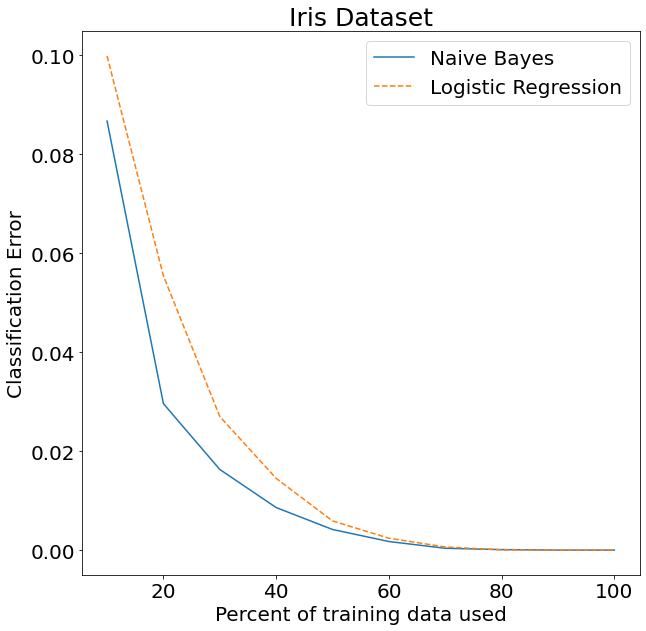

In [8]:
from sklearn.datasets import load_iris
iris_obj = load_iris()
# the code transform the iris dataset to a dataframe
iris = pd.DataFrame(iris_obj.data, columns=iris_obj.feature_names,index=pd.Index([i for i in range(iris_obj.data.shape[0])])).join(pd.DataFrame(iris_obj.target, columns=pd.Index(["species"]), index=pd.Index([i for i in range(iris_obj.target.shape[0])])))

# rename the columns
iris.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

# prepare data
X = iris.drop(columns=['sepal_width', 'species']).to_numpy()
y = iris["species"].to_numpy()

# use stratified split to ensure that all classes appear in the split data
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=20)

# split training data into training and test data 
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# standardize data   
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# apply data to models and plot error
nbc = NBC(feature_types=['r', 'r', 'r'], num_classes=3)
lr = LogisticRegression()
nbc_err, lr_err = compareNBCvsLR(nbc, lr, X_train, y_train, X_test, y_test, X_train, y_train, X_test, y_test)
makePlot(nbc_err,lr_err, 'Iris Dataset')

**Dataset 1: Summary**

- No one-value-column / no duplicated rows
- Petal length and width are strongly correlated with species - class 2 species have longer and wider petal measures than in class 1
- Petal length and width are strong correlated to each other
- Sepal width is anti-correlated: class 0 has wider sepal measures than class 1, but correlation is not that strong. Therefore the feature has been removed from the dataset
- As the data has no missing values the same dataset can be used for both models
- Naive Bayes perfoms better at the beginning, but Logistic Regression catches up when up to 70% of the dataset. Both models perfom equally using the whole dataset.

**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records


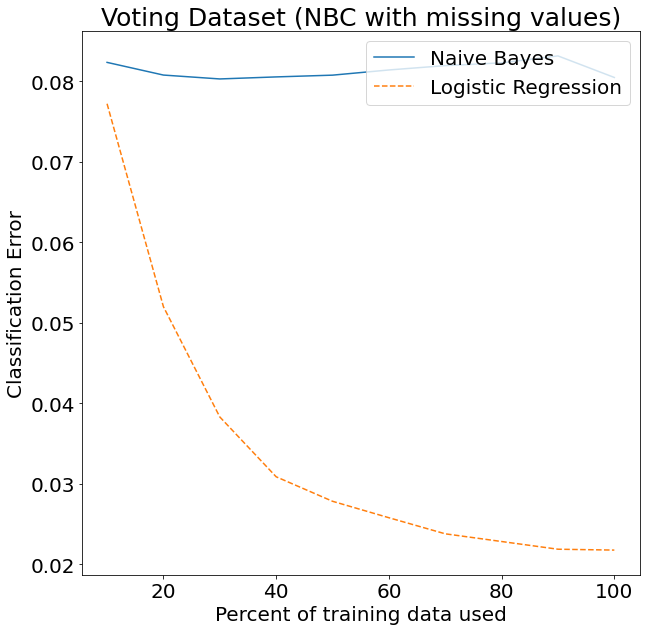

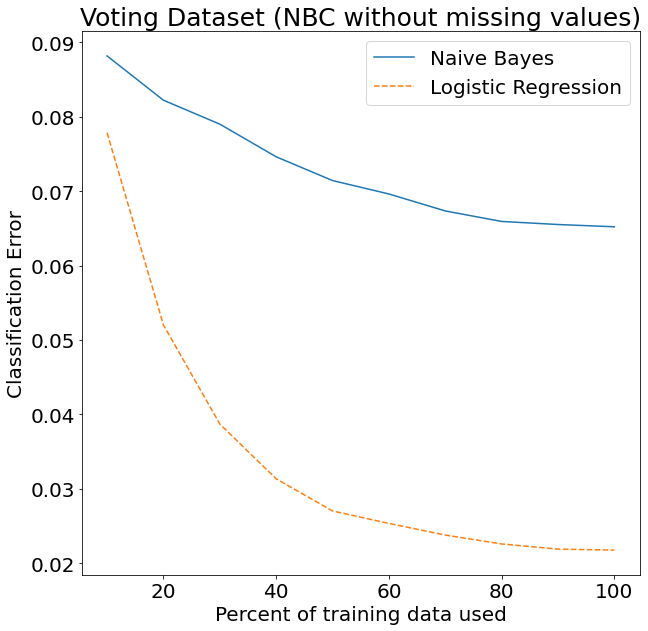

In [9]:
voting = pd.read_csv('./voting.csv')

# check null values
voting.isnull().sum(axis = 0)

# replace yes and no labels with 1 and 0 respectively
voting = voting.replace({'n': 0, 'y': 1})

# use stratified split to ensure that all classes appear in the split data   
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=20)

# split training data into training and test data 
for train_index, test_index in sss.split(voting, voting['label']):
    train, test = voting.loc[train_index], voting.loc[test_index]

# prepare nbc data with missing values
X_train_nbc = train.drop(columns=['label'])
feature_types = ['b' for item in X_train_nbc.columns] # apply list comprehension to get feature list for nbc
X_train_nbc = X_train_nbc.to_numpy()
y_train_nbc = train['label'].to_numpy()
X_test_nbc = test.drop(columns=['label']).to_numpy()
y_test_nbc = test['label'].to_numpy()

# remove nan values
train = train.dropna()
test = test.dropna()

# prepare logistic regression data without missing values
X_train_lr = train.drop(columns=['label']).to_numpy()
y_train_lr = train['label'].to_numpy()
X_test_lr = test.drop(columns=['label']).to_numpy()
y_test_lr = test['label'].to_numpy()

# apply data to models and plot error
nbc = NBC(feature_types=feature_types, num_classes=2)
lr = LogisticRegression()
nbc_err, lr_err = compareNBCvsLR(nbc, lr, X_train_nbc, y_train_nbc, X_test_nbc, y_test_nbc, X_train_lr, y_train_lr, X_test_lr, y_test_lr)
makePlot(nbc_err,lr_err, 'Voting Dataset (NBC with missing values)')
nbc_err, lr_err = compareNBCvsLR(nbc, lr, X_train_lr, y_train_lr, X_test_lr, y_test_lr, X_train_lr, y_train_lr, X_test_lr, y_test_lr)
makePlot(nbc_err,lr_err, 'Voting Dataset (NBC without missing values)')

**Dataset 2: Summary**

- Two classes: democrat, republican
- 16 boolean features
- Converted strings 'y' and 'n' to 1 and 0 respectively
- No standardization can be applied since only boolean features are present in the dataset.
- Several missing values present, especially in feature "export-administration-act-south-africa" - In case of Logistic Regression all missing values must be removed, which leads to a significant reduction of the dataset size. Nevertheless the Logistic Regression model outperforms Naive Bayes even though for this model more data (including missing values) can be used. Interestingly, Naive Bayes is not able to perfom much better on larger datasets where as Logistic regression can improve its performance in relation to its error which is already low using only 10 percent of the data.
- The performance of Naive Bayes can be improved by removing the missing values from the dataset.

**Dataset 3: Car Evaluation Dataset**

https://archive.ics.uci.edu/ml/datasets/car+evaluation

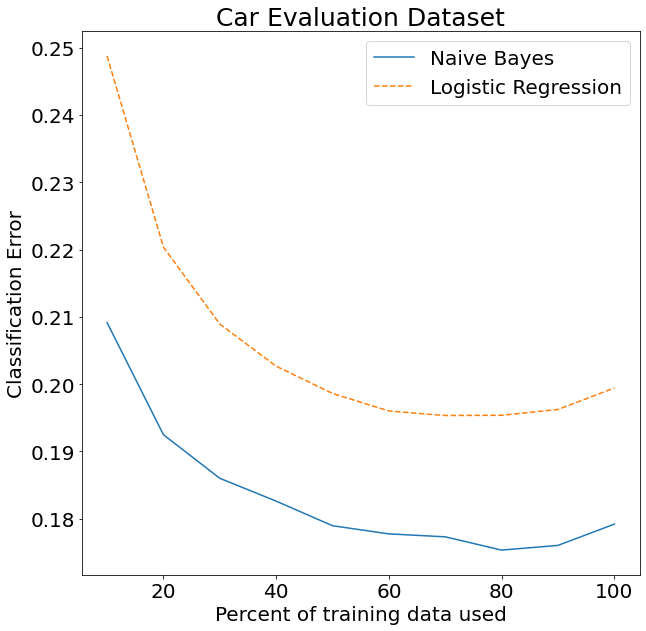

In [10]:
car = pd.read_csv('./car.csv')

# apply ordinal encoding on dataset
car['buying'] = car['buying'].replace({'low': 0, 'med': 1, 'high': 2, 'vhigh': 3})
car['maint'] = car['maint'].replace({'low': 0, 'med': 1, 'high': 2, 'vhigh': 3})
car['doors'] = car['doors'].replace({'4': 2, '2': 0, '3': 1, '5more': 3})
car['persons'] = car['persons'].replace({'4': 1, '2': 0,'more': 2})
car['lug_boot'] = car['lug_boot'].replace({'small': 0, 'med': 1, 'big': 2})
car['safety'] = car['safety'].replace({'low': 0, 'med': 1, 'high': 2})
car['acceptability'] = car['acceptability'].replace({'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3})

# use stratified split to ensure that all classes appear in the split data   
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=20)

# split training data into training and test data 
for train_index, test_index in sss.split(car, car['acceptability']):
    train, test = car.loc[train_index], car.loc[test_index]

# prepare data
X_train = train.drop(columns=['acceptability'])
feature_types = ['c' for item in X_train.columns] # apply list comprehension to get feature list for nbc
X_train = X_train.to_numpy()
y_train = train["acceptability"].to_numpy()
X_test = test.drop(columns=['acceptability']).to_numpy()
y_test = test["acceptability"].to_numpy()

# apply data to models and plot error
nbc = NBC(feature_types=feature_types, num_classes=4)
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
nbc_err, lr_err = compareNBCvsLR(nbc, lr, X_train, y_train, X_test, y_test, X_train, y_train, X_test, y_test)
makePlot(nbc_err,lr_err, 'Car Evaluation Dataset')


**Dataset 3: Summary**

- 4 classes: 'unacc', 'acc', 'good', 'vgood' - the classes are unbalanced, the class 'unacc' appears more often in data than the other classes. To solve this problem several methods like combining the classes 'good' and 'vgood', downsampling the class 'unacc' or upsampling the other classes have been applied. But this methods would ultimately deviate the uniform distributions. Another method would be to ensure that every category in each feature appears at least once in the training and testing data by adding additional occurences of each category in each feature. To generalize this problem to other datasets this is managed directly in the multinomial distribution implementation. To ensure that the Logistic regression is aware of the unbalanced distribution the attribute class_weight="balanced" can be applied.
- 6 categorical features - all features are evenly distributed (the categories vary between 3 or 4 categories, each category with the same probability). As an implicit order can been seen in the data, an ordinal coding scheme has been applied to transform the features into integers.
- No missing values are present
- No standardization can be applied since only categorical features are present in the dataset.
- Both models can improve the accuracy when adding more data to the training set. Interestingly, Naive Bayes outperforms Logistic Regression. This result must certainly be further analysed. As classes are unbalanced the Naive Bayes classifier could have learned only to output 'unacc' in most cases as this class has been seen the most during training. 

**Dataset 4: Breast Cancer Dataset**

https://archive.ics.uci.edu/ml/datasets/breast+cancer

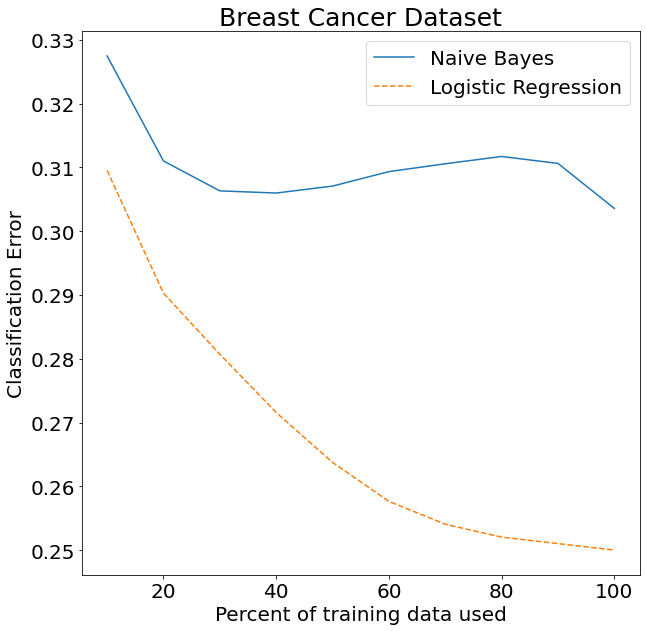

In [11]:
from sklearn.preprocessing import OneHotEncoder 
cancer = pd.read_csv('./breast-cancer.csv')

# apply ordinal encoding on dataset
cancer['Class'] = cancer['Class'].replace({'no-recurrence-events': 1, 'recurrence-events': 0})
cancer['age'] = cancer['age'].replace({'20-29': 0, '30-39': 0, '40-49': 1, '50-59': 2, '60-69': 3, '70-79': 3 })
cancer['tumor-size'] = cancer['tumor-size'].replace({'0-4': 0, '5-9': 0,'10-14': 1, '15-19': 2, '20-24': 3, '25-29': 4, '30-34': 5, '35-39': 6, '40-44': 7, '45-49': 8, '50-54': 8})
cancer['inv-nodes'] = cancer['inv-nodes'].replace({'0-2': 0, '3-5': 1, '6-8': 2, '9-11': 2, '12-14': 2, '15-17': 2, '24-26': 2})
cancer['deg-malig'] = cancer['deg-malig'].replace({1: 0, 2: 1, 3: 2})

# drop this category because occurence too low and is present in both classes
cancer = cancer[cancer['menopause'] != 'lt40']

# reset index
cancer = cancer.reset_index(drop=True)

#Using pandas dummies function to apply one hot encoding - drop one column to ensure linear independence
cancer = pd.get_dummies(cancer, columns=['menopause', 'node-caps', 'breast', 'breast-quad', 'irradiat'], prefix_sep='_', drop_first=True).astype('int')

# use stratified split to ensure that all classes appear in the split data   
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=20)

# split training data into training and test data 
for train_index, test_index in sss.split(cancer, cancer['Class']):
    train, test = cancer.loc[train_index], cancer.loc[test_index]
     
# prepare data
X_train = train.drop(columns=['Class'])
feature_types = ['c' if item < 4 else 'b' for item in range(len(X_train.columns))] # apply list comprehension to get feature list for nbc - cave: first 4 columns are categorical features
X_train = X_train.to_numpy()
y_train = train["Class"].to_numpy()
X_test = test.drop(columns=['Class']).to_numpy()
y_test = test["Class"].to_numpy()

# apply data to models and plot error
nbc = NBC(feature_types=feature_types, num_classes=2)
lr = LogisticRegression()
nbc_err, lr_err = compareNBCvsLR(nbc, lr, X_train, y_train, X_test, y_test, X_train, y_train, X_test, y_test)
makePlot(nbc_err,lr_err, 'Breast Cancer Dataset')

**Dataset 4: Summary**

- 2 classes: 'no-recurrence-events', 'recurrence-events' - the classes are encoded to 0 and 1 respectively
- 9 categorical features - for the features 'menopause', 'node-caps', 'breast', 'breast-quad', 'irradiat' no implicit order exist. One-hot encoding has been chosen for these features, the first column of each feature has been dropped to ensure linear independence. Additionally the category 'lt40' in the feature 'menopause' has been dropped because the occurence (7) appears to be too low to have an impact on the training. Especially because the category is present in both classes. Ordinal encoding has been used for the other features:
    - 'age' and 'tumor-size': The first and last two categories have been combined to ensure enough data in each category
    - 'inv-nodes': The last 5 categories have been combined to ensure enough data in each category 
- No missing values are present
- No standardization can be applied since only categorical features are present in the dataset.
- Both models can improve the accuracy when adding more data to the training set but Logistic regression reaches a lower error throughout the whole experiment.

**Dataset 5: Ionosphere Dataset**

https://archive.ics.uci.edu/ml/datasets/ionosphere

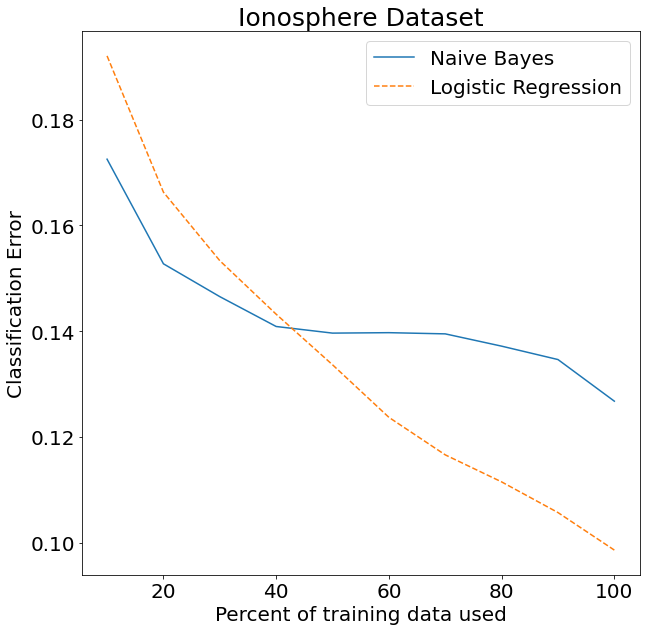

In [12]:
from sklearn.preprocessing import StandardScaler

ionosphere = pd.read_csv('./ionosphere.csv')
ionosphere = ionosphere.replace({'g': 0, 'b': 1})

# Create correlation matrix
corr_matrix = ionosphere.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.5
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]

# drop feature2 since it contains only value 0
to_drop.append("feature2")

# use stratified split to ensure that all classes appear in the split data   
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=20)

# split training data into training and test data 
for train_index, test_index in sss.split(ionosphere, ionosphere['label']):
    train, test = ionosphere.loc[train_index], ionosphere.loc[test_index]

# prepare nbc data with missing values
X_train = train.drop(columns=to_drop)

feature_types = []

for i in range (len(X_train.columns)):
    if i == 0:
        feature_types.append("b")
    else:
        feature_types.append("r")
        
# prepare data
X_train = X_train.to_numpy()
y_train = train["label"].to_numpy()
X_test = test.drop(columns=to_drop).to_numpy()
y_test = test["label"].to_numpy()

# Standardize data (without the first boolean feature)
scaler = StandardScaler()
X_train[:, 1:] = scaler.fit_transform(X_train[:, 1:])
X_test[:, 1:] = scaler.transform(X_test[:, 1:])

# apply data to models and plot error
nbc = NBC(feature_types=feature_types, num_classes=2)
lr = LogisticRegression()
nbc_err, lr_err = compareNBCvsLR(nbc, lr, X_train, y_train, X_test, y_test, X_train, y_train, X_test, y_test)
makePlot(nbc_err,lr_err, 'Ionosphere Dataset')

**Dataset 5: Summary**
- 34 features
- 2 labels "g" and "b"
- 1 feature with binary values "0" and "1"
- 1 feature row with only "0" values
- 32 features with continuous values
- No missing values are present
- Use Bernoulli distribution for the binary value future ("b") and gaussian distribution ("r") for the remaining features
- In order to optimize the models we sort out features which have relatively high correlations amongst each other - we applied a threshold of 0.5 as when looking over the correlation matrix such correlation could be considered high
- However, we kept features which are highly correlated with the label itself (which would otherwise be dropped) this was the case for feature 2
- All continuous features have been standardized
- Both models manage to decrease the error when using more data. Naive Bayes can achieve a better result using up to 40% of the training data, after that only a slight error reduction can be seen where as Logistic Regression further reduces its error.

**Dataset 6: Sonar Dataset**

http://archive.ics.uci.edu/ml/datasets/connectionist+bench+%28sonar,+mines+vs.+rocks%29

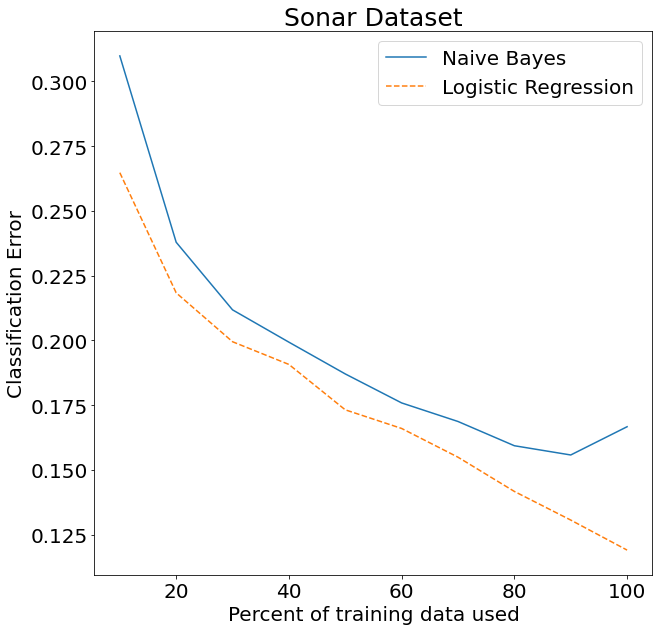

In [13]:
from sklearn.preprocessing import StandardScaler

sonar = pd.read_csv('./sonar.csv')

# because most of the data is skewed we apply the logarithm on whole data (without labels)
sonar_features = sonar.drop(columns=['label'])
sonar_label = pd.DataFrame(sonar['label'])
sonar_features = sonar_features.apply(lambda x: x.replace(0,10 ** -10)) # prevent infinite number by setting 0 values to a small non-zero value
sonar_features = sonar_features.apply(lambda x: np.log(x))
sonar = pd.concat([sonar_features,sonar_label], axis=1, ignore_index=False)

# use stratified split to ensure that all classes appear in the split data   
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=20)

# split training data into training and test data 
for train_index, test_index in sss.split(sonar, sonar['label']):
    train, test = sonar.loc[train_index], sonar.loc[test_index]

# prepare data   
X_train = train.drop(columns=['label'])
feature_types = ['r' for item in X_train.columns] # apply list comprehension to get feature list for nbc
X_train = X_train.to_numpy()
y_train = train["label"].to_numpy()
X_test = test.drop(columns=['label']).to_numpy()
y_test = test["label"].to_numpy()

# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# apply data to models and plot error
nbc = NBC(feature_types=feature_types, num_classes=2)
lr = LogisticRegression()
nbc_err, lr_err = compareNBCvsLR(nbc, lr, X_train, y_train, X_test, y_test, X_train, y_train, X_test, y_test)
makePlot(nbc_err,lr_err, 'Sonar Dataset')

**Dataset 6: Summary**
- 60 features
- All features with continuous values
- Therfore gaussian distribution ("r") for all the features
- No missing values in the dataset
- Similar to the above Dataset 5 we also tried to sort out highly correlated features. In contrast to the Dataset 5 within this dataset we noticed highly correlated features above 0.9. However, droping highly correlated features(or less ocrrelated features) did not increase the performance of the models but rather decreased its performance.
- Further we tried to keep only features which have a high correlation with the label in relative terms (above 0.3). However, this did neither improve the performance of the models.
- Eventually, the models with the best performance were the ones where all features were kept, which is why we did not drop any feature for dataset 6
- Also the combination of the last two points did not improve the performance of the model, but as we analysed the distributions of the feature, it can be seen that most of the data is skewed (left or right), therefore by taking the logarithm then skewness for most of the features could be flattened. After the splitting the data has been standardized.
- Both models manage to decrease the error when using more training data. After 50% training data Naive Bayes can only slightly improve its performance where as Logistic Regression has not reached a plateau yet.